In [1]:
# necessary libraries for prediciton
import utils
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Useful Functions

In [2]:
def pretty_matrix(matrix, row_label, col_label):
    """Pretty print of the given matrix """

    # Restraining labels that are too big
    row_label = [el[:10] + '..' if len(el) > 10 else el
                for el in row_label]
    col_label = [el[:10] + '..' if len(el) > 10 else el
                for el in col_label]

    # Stringfying everything & Joining top label
    s_matrix = [list([" "] + (col_label))] + \
               [[row_label[row_idx]] + \
                [str(e) for e in row] for row_idx, row in enumerate(matrix)]

    # Length of each matrix column
    len_s = [max(map(len, col)) for col in zip(*s_matrix)]

    # Cell formatation
    formatation = '\t'.join('{{:{}}}'.format(x) for x in len_s)

    # Apply cell formation to each matrix element
    pretty_mat = [formatation.format(*row) for row in s_matrix]

    # Print Pretty Matrix
    print('\n'.join(pretty_mat))


def display_confusion_matrix(values):
    '''Display the given array as a confusion matrix'''
    pretty_matrix([values[0:2], values[2:4]],
                  ['Actual NO', 'Actual YES'],
                  ['Predic NO', 'Predic YES'])

In [3]:
def plot_roc_auc(fpr, tpr, roc_auc):
    '''Plot the ROC-AUC curve'''
    fig, ax = plt.subplots()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'w--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([0, 1])
    ax.fill_between(fpr, 0, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
def normalize_columns(df, columns):
    '''Normalize the given columns for range between [0, 1]'''
    for col in columns:
        col_min = df[col].min()
        col_max =  df[col].max()
        
        df[col] = (df[col] - col_min)/\
                    (col_max - col_min)
        
def normalize_df(df):
    '''Normalize all columns of the given df'''
    normalize_columns(df, df.columns)

In [5]:
def apply_PCA(df, variance_val=0.95, debug=True):
    '''Apply the PCA algorithm to given dataframe,
    using the given variance val to trim the df'''
    # Necessary to normalize all data to use PCA
    scaler=StandardScaler()
    X_scaled=scaler.fit_transform(df)

    # PCA - keep, by default mode, 90% variance
    pca = PCA(variance_val)    
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)

    if debug:
        ex_variance=np.var(X_pca,axis=0)
        ex_variance_ratio = ex_variance/np.sum(ex_variance)
        print(' > Impact in total variance of each generated feature by PCA:')
        print(ex_variance_ratio)

    principal_df = pd.DataFrame(data = X_pca, index = df.reset_index()['loan_id'])
    
    return (principal_df, pca)

In [6]:
def auc_scorer(y_true, y_pred):
    '''Scorer of Area Under Curve value'''
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

# Prediction Algorithms

* Logistic Regression
* Decision Tree
* Random Forest
* Gradient Boosting

In [7]:
def create_LR():
    '''Create a Logistic Regression model'''
    return LogisticRegression()

In [8]:
def create_DT():
    '''Create a new Decision Tree'''
    # Useful DecisionTree tutorial:
    # https://www.datacamp.com/community/tutorials/decision-tree-classification-python
    return DecisionTreeClassifier()

In [9]:
def create_RF():
    '''Create a new Ranfom Forest model'''
    return RandomForestClassifier()

In [10]:
def create_GB():
    '''Create a new Gradient Boosting model'''
    return GradientBoostingClassifier()

# Prediction

* Predictions are done in this notebook.
* It is also useful to compare how serveral algorithms perform against one another.

In [11]:
pd.set_option('display.max_columns', 200)

# Useful Macros
K_FOLD_NUM_SPLITS = 5
SEED = 42
USE_PCA = False
UNDERSAMPLE = False
UNDERSAMPLE_RATIO = 0.3

# Pretty printer
pp = pprint.PrettyPrinter(indent=4)

In [12]:
dataset =  utils.read_csv_to_df('dataset/preprocessed_data.csv')

if UNDERSAMPLE:
    print(' > Apllying undersampling:')
    entries_df = len(dataset.index)

    # Getting all minor class cases into final dataset
    minor_df = dataset[dataset['status'] == -1]
    num_minor = len(minor_df.index)
    
    print('\t> Classes initial ratio: %f - %f\n\t> Dataset size: %i' %
         (num_minor / entries_df, (entries_df - num_minor) / entries_df, entries_df))

    # Selecting equal number from major class
    major_df = dataset[dataset['status'] == 1].sample(n=int((num_minor / UNDERSAMPLE_RATIO) - num_minor),
                                                      random_state=SEED)
    num_major = len(major_df.index)
    total_under = num_minor + num_major
    
    print('\t> Classes final ratio: %f - %f\n\t> Dataset size: %i' % 
          (num_minor / total_under, num_major / total_under, total_under))

    # Concatenting to main dataframe
    dataset = pd.concat([minor_df, major_df])

dataset = dataset.set_index('loan_id')
display(dataset)

# Normalizing dataset
print(' > Dataset after normalization')
normalize_df(dataset)
display(dataset)

,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,IC_mean,withdrawal_ratio,ratio_RAB,owner_count,sanctions_count,sanctions_std,CC_std,RAB_min,credit_ratio,ratio_CC,amount,payments,last_balance,max_value_in_account_to_loan_ratio,status
loan_id,,,,,,,,,,,,,,,,,,,
5314,1100.0,1.0,20100.0,0.0,0.000000,0.000000,0.000000,1,0.0,0.0,3774.806838,0.0,1.000000,1.000000,96396,8033,20100.0,0.208515,-1
5316,700.0,1.0,62612.0,0.0,168.540000,0.540541,0.216216,1,0.0,0.0,13044.711945,-4167.0,0.459459,0.324324,165960,4610,52208.9,0.726156,1
6863,800.0,1.0,27534.0,0.0,92.625000,0.375000,0.125000,1,0.0,0.0,2050.609665,-7936.0,0.625000,0.083333,127080,2118,20272.8,0.390230,1
5325,1000.0,1.0,47508.0,0.0,160.360000,0.480000,0.080000,1,0.0,0.0,2050.609665,-6994.0,0.520000,0.080000,105804,2939,34307.3,0.622836,1
7240,600.0,1.0,40788.0,0.0,190.183333,0.518519,0.111111,1,0.0,0.0,0.000000,-9499.0,0.481481,0.037037,274740,4579,41112.9,0.447307,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6818,200.0,1.0,101122.0,0.0,145.472727,0.593023,0.209302,2,0.0,0.0,6517.394689,-2587.0,0.406977,0.151163,155616,3242,60694.1,0.483845,1
5625,800.0,1.0,56990.0,0.0,223.050000,0.525424,0.000000,1,0.0,0.0,13832.527973,0.0,0.474576,0.271186,222180,3703,59578.8,0.588078,-1
6805,800.0,1.0,51200.0,0.0,114.216667,0.487179,0.153846,1,0.0,0.0,9517.351233,-4719.0,0.512821,0.205128,45024,938,38384.3,1.413897,1


 > Dataset after normalization


,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,IC_mean,withdrawal_ratio,ratio_RAB,owner_count,sanctions_count,sanctions_std,CC_std,RAB_min,credit_ratio,ratio_CC,amount,payments,last_balance,max_value_in_account_to_loan_ratio,status
loan_id,,,,,,,,,,,,,,,,,,,
5314,0.273848,1.0,0.094611,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.145173,1.000000,1.000000,1.000000,0.171345,0.823266,0.128125,0.012673,0.0
5316,0.249638,1.0,0.250351,1.0,0.503220,0.713053,0.578378,0.0,0.0,0.0,0.501677,0.716973,0.286947,0.319696,0.301732,0.457951,0.377597,0.067419,1.0
6863,0.255691,1.0,0.121845,1.0,0.276556,0.494681,0.334375,0.0,0.0,0.0,0.078863,0.460979,0.505319,0.077055,0.228857,0.191996,0.129468,0.031892,1.0
5325,0.267796,1.0,0.195018,1.0,0.478797,0.633191,0.214000,0.0,0.0,0.0,0.078863,0.524961,0.366809,0.073699,0.188979,0.279616,0.238510,0.056492,1.0
7240,0.243586,1.0,0.170400,1.0,0.567842,0.684003,0.297222,0.0,0.0,0.0,0.000000,0.354819,0.315997,0.030441,0.505623,0.454642,0.291386,0.037928,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6818,0.219376,1.0,0.391429,1.0,0.434347,0.782286,0.559884,1.0,0.0,0.0,0.250648,0.824289,0.217714,0.145349,0.282344,0.311953,0.443523,0.041792,1.0
5625,0.255691,1.0,0.229755,1.0,0.665974,0.693112,0.000000,0.0,0.0,0.0,0.531975,1.000000,0.306888,0.266195,0.407108,0.361153,0.434858,0.052816,0.0
6805,0.255691,1.0,0.208544,1.0,0.341024,0.642662,0.411538,0.0,0.0,0.0,0.366021,0.679481,0.357338,0.199684,0.075056,0.066062,0.270186,0.140155,1.0


In [13]:
STATUS_COL = dataset.columns.get_loc("status")

In [14]:
# Setting X and Y
X = dataset.iloc[:, 0:STATUS_COL]
y = dataset.iloc[:, [STATUS_COL]]
display(X.head())

if USE_PCA:
    print(' > Applying PCA to X_train:')
    X, pca = apply_PCA(X, debug=True)
    display(X.head())

,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,IC_mean,withdrawal_ratio,ratio_RAB,owner_count,sanctions_count,sanctions_std,CC_std,RAB_min,credit_ratio,ratio_CC,amount,payments,last_balance,max_value_in_account_to_loan_ratio
loan_id,,,,,,,,,,,,,,,,,,
5314,0.273848,1.0,0.094611,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.145173,1.000000,1.000000,1.000000,0.171345,0.823266,0.128125,0.012673
5316,0.249638,1.0,0.250351,1.0,0.503220,0.713053,0.578378,0.0,0.0,0.0,0.501677,0.716973,0.286947,0.319696,0.301732,0.457951,0.377597,0.067419
6863,0.255691,1.0,0.121845,1.0,0.276556,0.494681,0.334375,0.0,0.0,0.0,0.078863,0.460979,0.505319,0.077055,0.228857,0.191996,0.129468,0.031892
5325,0.267796,1.0,0.195018,1.0,0.478797,0.633191,0.214000,0.0,0.0,0.0,0.078863,0.524961,0.366809,0.073699,0.188979,0.279616,0.238510,0.056492
7240,0.243586,1.0,0.170400,1.0,0.567842,0.684003,0.297222,0.0,0.0,0.0,0.000000,0.354819,0.315997,0.030441,0.505623,0.454642,0.291386,0.037928


# Hyper Parameter Tunning

## Random Search 1st to apporach the best solution, GridSearch to refine it

In [15]:
def getLogisticRegressionBest(X, y, debug=True):
    '''Get the Logistic Regression Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 20, 4)]
    max_depth.append(None)

    # Create the random grid
    grid = {'penalty': ['l2', 'none'],
            'C': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
            'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'class_weight': ["balanced", None]}
    
    if debug:
        pp.pprint(grid)
    
    # Using the grid search for best hyperparameters
    lr = create_LR()
    lr_grid = GridSearchCV(estimator = lr,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    lr_grid = lr_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', lr_grid.best_score_)
        print('Best Params: ', lr_grid.best_params_)
        
    # Return score, method & params tuple
    return (lr_grid.best_score_, 'Logistic Regression', lr_grid.best_params_)

In [16]:
def getDecisionTreeBest(X, y, debug=True):
    '''Get the Decision Tree Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 20, 4)]
    max_depth.append(None)

    # Create the random grid
    grid = {'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_features': ['auto', 'sqrt'],
            'max_depth': max_depth,
            'min_samples_split':  [2, 5, 10],
            'min_samples_leaf':  [1, 2, 4],
            'class_weight': ["balanced", None]}
    
    if debug:
        pp.pprint(grid)
    
    # Using the grid search for best hyperparameters
    dt = create_DT()
    dt_grid = GridSearchCV(estimator = dt,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    dt_grid = dt_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', dt_grid.best_score_)
        print('Best Params: ', dt_grid.best_params_)
        
    # Return score, method & params tuple
    return (dt_grid.best_score_, 'Decision Tree', dt_grid.best_params_)

In [17]:
def getRandomForestBest(X, y, debug=True):
    '''Get the Random Forest Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 16, 4)]
    max_depth.append(None)

    # Create the random grid
    grid = {'n_estimators': [int(x) for x in range(2, 14, 2)],
            'max_features': ['auto', 'sqrt'],
            'max_depth': max_depth,
            'criterion': ['gini', 'entropy'],
            'min_samples_split':  [2, 5, 10],
            'min_samples_leaf':  [1, 2, 4],
            'bootstrap': [True, False],
            'class_weight': ["balanced", "balanced_subsample", None]}
    
    if debug:
        pp.pprint(grid)
    
    # Using the grid search for best hyperparameters
    rf = create_RF()
    rf_grid = GridSearchCV(estimator = rf,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    rf_grid = rf_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', rf_grid.best_score_)
        print('Best Params: ', rf_grid.best_params_)
        
    # Return score, method & params tuple
    return (rf_grid.best_score_, 'Random Forest', rf_grid.best_params_)

In [18]:
def getGradientBoostBest(X, y, debug=True):
    '''Get the Gradient Boost Hyper Parameters'''

    # Create the grid parameters
    grid = {'n_estimators': [int(x) for x in range(2, 14, 2)],
            'learning_rate': [0.1, 0.3, 0.5, 0.7],
            'loss': ['deviance', 'exponential'],
            'criterion': ['friedman_mse', 'mse', 'mae'],
            'min_samples_split':  [2, 5, 10],
            'min_samples_leaf':  [1, 2, 4],
            'random_state': [SEED]}
    
    if debug:
        pp.pprint(grid)
    
    # Using the grid search for best hyperparameters
    gb = create_GB()
    gb_grid = GridSearchCV(estimator = gb,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    gb_grid = gb_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', gb_grid.best_score_)
        print('Best Params: ', gb_grid.best_params_)
        
    # Return score, method & params tuple
    return (gb_grid.best_score_, 'Gradient Boosting', gb_grid.best_params_)

In [19]:
# Getting the best algorithm
algorithms = [getLogisticRegressionBest(X, y),
              getDecisionTreeBest(X, y),
              getRandomForestBest(X, y)]
              # getGradientBoostBest(X, y)]
algorithms.sort(reverse=True, key=lambda el: el[0])

for index, entry in enumerate(algorithms):
    print('%i. %s - %f\n---------' % (index + 1, entry[1], entry[0]))
    
print('Best algorithm: %s' % algorithms[0][1])

{   'C': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'class_weight': ['balanced', None],
    'penalty': ['l2', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    4.2s finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.7929360049004627
Best Params:  {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
{   'class_weight': ['balanced', None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 6, 10, 14, 18, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'splitter': ['best', 'random']}
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:    9.9s finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.8094149563441123
Best Params:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
{   'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 6, 10, 14, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[Parallel(n_jobs=-1)]: Done 358 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2052 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 4558 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 6539 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9094 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 12209 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 15898 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 20147 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 24970 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 30353 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 32393 out of 32400 | elapsed:  5.4min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 32400 out of 32400 | elapsed:  5.4min finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will ch

Best Score:  0.8241993767447072
Best Params:  {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 8}
1. Random Forest - 0.824199
---------
2. Decision Tree - 0.809415
---------
3. Logistic Regression - 0.792936
---------
Best algorithm: Random Forest


## Using method with higher score with our data

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


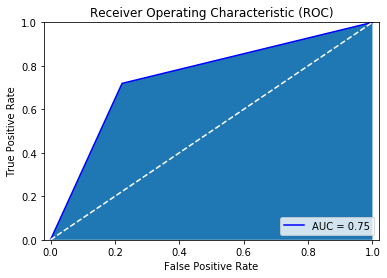

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


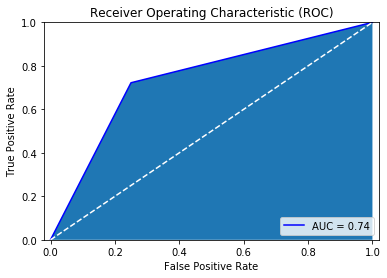

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


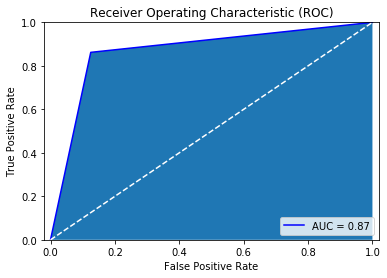

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


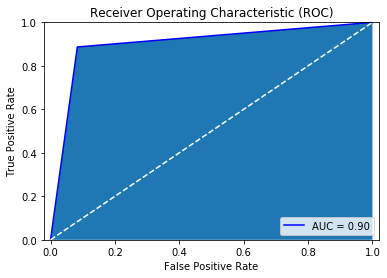

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


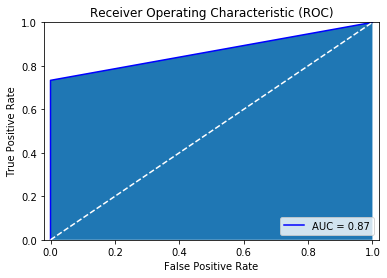

In [20]:
# Cross validation settings
auc_scores = []
confusion_matrixes = []
cv = KFold(n_splits=K_FOLD_NUM_SPLITS, random_state=SEED, shuffle=False)

# CHANGE THIS LINE TO CHANGE THE USED CLASSIFICATION METHOD
# classifier = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, min_samples_split=10, splitter='best')
# classifier = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.7, loss='deviance',
#                                         min_samples_leaf=2, min_samples_split=2, n_estimators=8, random_state=SEED)
classifier = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='entropy',
                                    max_depth=2, max_features='auto', min_samples_leaf=4,
                                    min_samples_split=2, n_estimators=8)


# Applying Cross validation
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training with this fold
    classifier.fit(X_train, y_train)
    
    # Testing & Measuring accuracy
    y_pred = classifier.predict(X_test)
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)

    auc_scores.append(auc)
    confusion_matrixes.append(metrics.confusion_matrix(y_test, y_pred).ravel())

    plot_roc_auc(fpr, tpr, auc)

In [21]:
# Printing the obtained results
print('Classification Method used:', classifier, '\n')
print('AUC scores:', auc_scores)
print('> Average: ', sum(auc_scores)/len(auc_scores))
for cf in confusion_matrixes:
    display_confusion_matrix(cf)

Classification Method used: RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=8, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False) 

AUC scores: [0.7485380116959064, 0.7361111111111112, 0.8685344827586207, 0.9017295597484277, 0.8666666666666667]
> Average:  0.8243159663961463
          	Predic NO	Predic YES
Actual NO 	7        	2         
Actual YES	16       	41        
          	Predic NO	Predic YES
Actual NO 	9        	3         
Actual YES	15       	39        
          	Predic NO	Predic YES
Actual NO 	7        	1         
Actual YES	8        	50        
          	Predic NO	Predic YES
Actual NO 

### After having our model trained we shall use the model on the data to be sumitted in the kaggle

In [22]:
test_dataset =  utils.read_csv_to_df('dataset/test_dataset.csv')
test_dataset = test_dataset.set_index('loan_id')
normalize_df(test_dataset)
display(test_dataset.head())

,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,IC_mean,withdrawal_ratio,ratio_RAB,owner_count,sanctions_count,sanctions_std,CC_std,RAB_min,credit_ratio,ratio_CC,amount,payments,last_balance,max_value_in_account_to_loan_ratio,status
loan_id,,,,,,,,,,,,,,,,,,,
5895,0.474157,1.0,0.360467,1.000000,0.689672,0.853462,0.546415,0.0,0.0,0.0,0.483870,0.628545,0.146538,0.175218,0.151641,0.131376,0.456208,0.071021,NaN
7122,0.433774,0.0,0.147094,0.870568,0.439087,0.808767,0.754731,0.0,0.1,0.0,0.726426,0.570286,0.191233,0.174929,0.436237,0.722049,0.117237,0.024341,NaN
6173,0.458202,1.0,0.341665,1.000000,0.539962,0.972884,0.887108,0.0,0.0,0.0,0.224621,0.819110,0.027116,0.011585,0.388292,0.472725,0.422345,0.024379,NaN
6142,0.479476,1.0,0.161846,1.000000,0.502754,0.906637,0.865191,1.0,0.0,0.0,0.006688,0.807015,0.093363,0.022770,0.370057,0.353321,0.361298,0.023877,NaN
5358,0.476817,1.0,0.237976,1.000000,0.249445,0.700179,0.359231,0.0,0.0,0.0,0.096925,0.790687,0.299821,0.285526,0.056981,0.302519,0.182821,0.061153,NaN


In [23]:
# We now remove the Y column with NaNs
test_dataset = test_dataset.iloc[:, 0:STATUS_COL]

display(test_dataset.head())

,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,IC_mean,withdrawal_ratio,ratio_RAB,owner_count,sanctions_count,sanctions_std,CC_std,RAB_min,credit_ratio,ratio_CC,amount,payments,last_balance,max_value_in_account_to_loan_ratio
loan_id,,,,,,,,,,,,,,,,,,
5895,0.474157,1.0,0.360467,1.000000,0.689672,0.853462,0.546415,0.0,0.0,0.0,0.483870,0.628545,0.146538,0.175218,0.151641,0.131376,0.456208,0.071021
7122,0.433774,0.0,0.147094,0.870568,0.439087,0.808767,0.754731,0.0,0.1,0.0,0.726426,0.570286,0.191233,0.174929,0.436237,0.722049,0.117237,0.024341
6173,0.458202,1.0,0.341665,1.000000,0.539962,0.972884,0.887108,0.0,0.0,0.0,0.224621,0.819110,0.027116,0.011585,0.388292,0.472725,0.422345,0.024379
6142,0.479476,1.0,0.161846,1.000000,0.502754,0.906637,0.865191,1.0,0.0,0.0,0.006688,0.807015,0.093363,0.022770,0.370057,0.353321,0.361298,0.023877
5358,0.476817,1.0,0.237976,1.000000,0.249445,0.700179,0.359231,0.0,0.0,0.0,0.096925,0.790687,0.299821,0.285526,0.056981,0.302519,0.182821,0.061153


In [25]:
final_df = pd.DataFrame()

if USE_PCA:
    # Using train PCA and classifying
    scaler=StandardScaler()
    X_test_scaled=scaler.fit_transform(test_dataset)
    predictions_df = pd.DataFrame(data = pca.transform(X_test_scaled),
                                  index=test_dataset.reset_index()['loan_id'])
    display(predictions_df)

    predictions_df['Predicted'] = classifier.predict(predictions_df)
    final_df = predictions_df.reset_index()\
                    [['loan_id', 'Predicted']]\
                    .rename(columns={
                        'loan_id': 'Id'
                    })
    
else:
    final_df = test_dataset.copy()
    final_df['Predicted'] = classifier.predict(final_df)
    final_df = final_df.reset_index()\
                        [['loan_id', 'Predicted']]\
                        .rename(columns={
                            'loan_id': 'Id'
                        })\
                        .drop_duplicates()

final_df.loc[final_df["Predicted"]== 0.0, "Predicted"] = -1
display(final_df)

,Id,Predicted
0,5895,1.0
1,7122,-1.0
2,6173,1.0
3,6142,1.0
4,5358,1.0
...,...,...
349,4989,-1.0
350,5221,-1.0
351,6402,1.0
352,5346,1.0


In [26]:
# Outputting predictions to .csv
# CHANGE FILE NAME TO PRESERVE DIFFERENT INSTANCES
utils.write_df_to_csv(final_df, 'predictions', 'prediction.csv')